## Trying RNN with variable-length sequence

- [tutorial and data](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#sphx-glr-intermediate-char-rnn-classification-tutorial-py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torch.nn import utils

In [3]:
from glob import glob

In [4]:
def load_names(name_dir):
    dfs = []
    for f in glob(name_dir + "/*.txt"):
        names = [n.strip().lower() for n in open(f, "r").readlines()]
        langage = f.rsplit("/")[-1][:-4]
        df = pd.DataFrame({"name": names, "language": langage})
        dfs.append(df)
    return pd.concat(dfs, axis=0, ignore_index=True)[["name", "language"]]

name_df = load_names("/Users/pmal252d/ws/data/babynames/names/")

In [5]:
name_df.head()

,name,language
0,khoury,Arabic
1,nahas,Arabic
2,daher,Arabic
3,gerges,Arabic
4,nazari,Arabic


## data processing

In [53]:
class NameDataset(data.Dataset):
    def __init__(self, name_df):
        self.voc = set("".join(name_df.name))
        self.c2i = {c : i for i, c in enumerate(self.voc)}
        self.i2c = {i : c for c, i in self.c2i.items()}
        self.langs = set(name_df.language.unique())
        self.lan2i = {lan : i for i, lan in enumerate(self.langs)}
        self.i2lan = {i : lan for lan, i in self.lan2i.items()}
        self.max_name_len = int(name_df.name.str.len().max())
        self.names = torch.stack([self.name2tensor(n, 20) 
                                  for n in name_df.name],
                                 dim=0)
        self.lengths = name_df.name.str.len()
        self.langauges = self.langs2tensor(name_df.language)
        
    def __len__(self):
        return self.names.size(0)
    
    def __getitem__(self, i):
        return (self.names[i, ...], self.lengths[i], self.langauges[i])
    
    def name2tensor(self, name, max_name_len):
        """
        return tensor of (L, V): L name lenght, V voc size
        """
        x = torch.zeros([max_name_len, len(self.voc)])
        for c, letter in enumerate(name):
            x[c, self.c2i.get(letter)] = 1
        return x

    def langs2tensor(self, langs):
        return torch.IntTensor([self.lan2i[lang] for lang in langs])
    
name_ds = NameDataset(name_df)
name_batches = data.DataLoader(name_ds, batch_size=128, shuffle=True, num_workers=2)

In [54]:
## test data

for names, name_lens, languages in name_batches:
    print(names.size(), name_lens.size(), languages.size())
    break

torch.Size([128, 20, 58]) torch.Size([128]) torch.Size([128])


## hyperparameters

In [198]:
## hyperparameters
batch_size = name_batches.batch_size
seq_len = name_ds.max_name_len
input_size = len(name_ds.voc)
rnn_hidden_size = 64
fc1_hidden_size = 64
fc2_hidden_size = 64
output_size = len(name_ds.langs)


## models

In [199]:


class NameLanguageModel(nn.Module):
    def __init__(self):
        super(NameLanguageModel, self).__init__()
        self.rnn = nn.GRU(input_size=input_size,
                          hidden_size=rnn_hidden_size,
                          num_layers=1,
                          batch_first=True,
                          bidirectional=False)
        self.fc1 = nn.Linear(rnn_hidden_size, fc1_hidden_size)
        self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc1_hidden_size, fc2_hidden_size)
        self.d2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(fc2_hidden_size, output_size)
    def forward(self, x):
        batch_size = x.batch_sizes[0]
        h0 = Variable(torch.zeros(1, batch_size, rnn_hidden_size))
        out, _ = self.rnn(x, h0)
        out, out_len = utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = torch.stack([out[r, c-1, :] for r, c in enumerate(out_len)], dim=0)
        out = self.fc1(out)
        out = self.d1(out)
        out = F.elu(out)
        out = F.elu(self.d2(self.fc2(out)))
        logits = self.fc3(out)
        return logits
    
    
objective = nn.CrossEntropyLoss()

In [200]:
## test model
m = NameLanguageModel()

for names, name_lens, languages in name_batches:
    print(names.size(), name_lens.size(), languages.size())
    break


lens = name_lens.numpy()
i = np.argsort(lens)[::-1]
x = Variable(names[torch.from_numpy(i.astype(np.long))])
languages = Variable(languages[torch.from_numpy(i.astype(np.long))])
pack = utils.rnn.pack_padded_sequence(x, lens[i], batch_first=True)
y = m(pack)
print(y.size())
loss = objective(y, languages)
print(loss)

torch.Size([128, 20, 58]) torch.Size([128]) torch.Size([128])
torch.Size([128, 18])
Variable containing:
 2.8374
[torch.FloatTensor of size 1]



## training

In [201]:
n_epochs = 200
model = NameLanguageModel()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
model.train()
for epoch in range(n_epochs):
    for b, (names, name_lens, languages) in enumerate(name_batches):
        lens = name_lens.numpy()
        i = np.argsort(lens)[::-1]
        x = Variable(names[torch.from_numpy(i.astype(np.long))])
        languages = Variable(languages[torch.from_numpy(i.astype(np.long))])
        pack = utils.rnn.pack_padded_sequence(x, lens[i], batch_first=True)
        y = model(pack)
        loss = objective(y, languages)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 200 == 0:
            print(epoch, b, loss.data[0])

0 0 2.8497045040130615
1 0 1.6369879245758057
2 0 1.5047029256820679
3 0 1.1885336637496948
4 0 1.468309998512268
5 0 1.0880311727523804
6 0 1.3284090757369995
7 0 1.07448148727417
8 0 0.9483917951583862
9 0 0.8839095234870911
10 0 1.0254865884780884
11 0 0.940910279750824
12 0 0.9384251832962036
13 0 0.8562106490135193
14 0 1.0270323753356934
15 0 0.8971002101898193
16 0 0.9418807625770569
17 0 0.8940801620483398
18 0 0.704446017742157
19 0 0.6640272736549377
20 0 0.8421040177345276
21 0 0.6869194507598877
22 0 0.7568899393081665
23 0 0.5370824337005615
24 0 0.8838623762130737
25 0 0.647059440612793
26 0 0.7286583781242371
27 0 0.65517657995224
28 0 0.590233564376831
29 0 0.8488616943359375
30 0 0.7865766286849976
31 0 0.5622156262397766
32 0 0.6578609347343445
33 0 0.7616690993309021
34 0 0.6238940954208374
35 0 0.6186093688011169
36 0 0.5099834203720093
37 0 0.5622609853744507
38 0 0.46940815448760986
39 0 0.6746248602867126
40 0 0.48550084233283997
41 0 0.4512198269367218
42 0 0.59

In [202]:
# model = NameLanguageModel()

def predict_name_lang(model, name):
    x = Variable(name_ds.name2tensor(name, name_ds.max_name_len)).unsqueeze(dim=0)
    pack = utils.rnn.pack_padded_sequence(x, [len(name)], batch_first=True)
    y = model(pack)
#     print(y)
    _, iclass = torch.topk(y, k=1)
#     print(iclass)
    lang = name_ds.i2lan[int(iclass.data[0].numpy())]
    return lang

In [203]:
predict_name_lang(model, "chris")

'Greek'

In [204]:
predict_name_lang(model, "partha")

'French'

In [205]:
%%time
model.eval()
predictions = np.array([predict_name_lang(model, n) for n in name_df.name])

CPU times: user 1min 29s, sys: 383 ms, total: 1min 29s
Wall time: 45.3 s


In [206]:
name_df["prediction"] = predictions

In [207]:
cm = pd.pivot_table(name_df, index="language", columns="prediction", aggfunc="size").fillna(0)

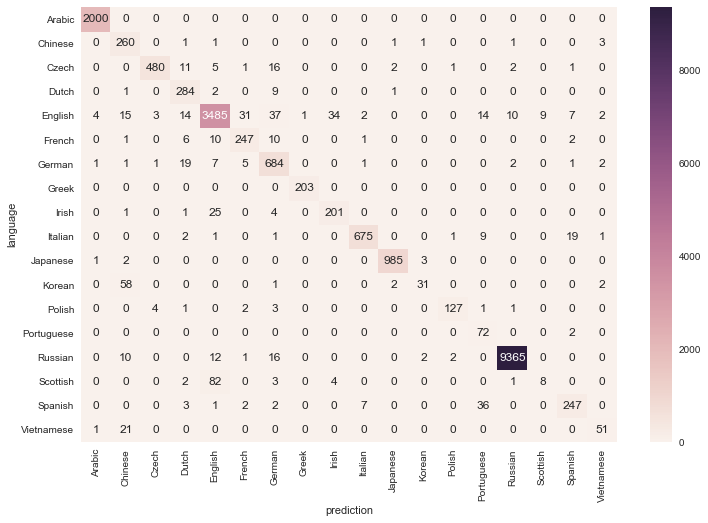

In [208]:
import seaborn as sb
plt.figure(figsize=(12, 8))
sb.heatmap(cm, annot=True, fmt=".0f", )